In [ ]:
pip install helper

**importing improtant libraries**

In [3]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Reading the dataset**

In [4]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [5]:
q=dataframe.query('Country=="Italy"')
df=q.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     225435
2020-05-18     225886
2020-05-19     226699
2020-05-20     227364
2020-05-21     228006

[121 rows x 1 columns]

**Spliting the dataset**

In [7]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28     201505
2020-04-29     203591
2020-04-30     205463
2020-05-01     207428
2020-05-02     209328
2020-05-03     210717
2020-05-04     211938
2020-05-05     213013
2020-05-06     214457
2020-05-07     215858
2020-05-08     217185
2020-05-09     218268
2020-05-10     219070
2020-05-11     219814
2020-05-12     221216
2020-05-13     222104
2020-05-14     223096
2020-05-15     223885
2020-05-16     224760
2020-05-17     225435
2020-05-18     225886
2020-05-19     226699
2020-05-20     227364
2020-05-21     228006

In [8]:
# Series to test
column_name = df.columns[0]
print("%s cases will be used for the analysis" % column_name)

Confirmed cases will be used for the analysis


In [9]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [10]:
df.tail()

Confirmed
Date                 
2020-05-17     225435
2020-05-18     225886
2020-05-19     226699
2020-05-20     227364
2020-05-21     228006

In [11]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [12]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17     225435
2020-05-18     225886
2020-05-19     226699
2020-05-20     227364
2020-05-21     228006

In [13]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [14]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [15]:
#Mean absolute percentage error (MAPE)
def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [17]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [18]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [19]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 126245.64493602957, 88824.71900826447)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 126245.64493602957, 88824.71900826447)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 89347.22685099531, 82677.2081825012)
([(0, 0, 0), (0, 0, 0, 365), 't'], 40009.90350087186, 34506.646890658005)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 26899.388033992804, 22192.86184964072)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 63008.47419394191, 44484.644771812156)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 95889.61004330906, 84756.76520867016)
([(0, 0, 1), (0, 0, 0, 365), 't'], 20047.32687245586, 16819.531049010857)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 18688.768826214888, 15844.496451880115)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 32422.11907185508, 22939.78356169607)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 66167.39096523591, 45752.63422768882)
([(0, 0, 2), (0, 0, 0, 365), 't'], 10684.4497715682, 8498.56422207142)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 243524.64442480978, 126588.96332512313)
([(0, 1, 0), (0, 0, 0, 365), 'n

In [20]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Confirmed
[(2, 0, 2), (0, 0, 0, 365), 't'] 404.60694170155557 291.55402851745254


In [21]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

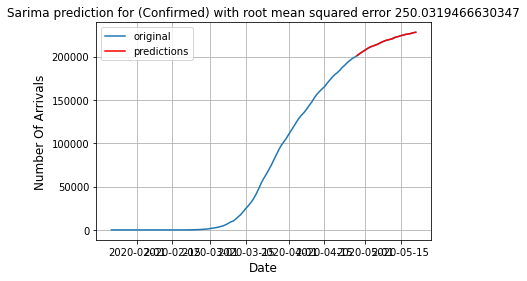

In [22]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [23]:
mape(test,predictions)

4.128152341926669

In [24]:
#Recovered Cases in Italy '''

RECOVERED CASES

In [25]:
q=dataframe.query('Country=="Italy"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     125176
2020-05-18     127326
2020-05-19     129401
2020-05-20     132282
2020-05-21     134560

[121 rows x 1 columns]

**Spilitng the dataset**

In [26]:
trainr=dfr[0:97]
testr=dfr[97:]
testr

Recovered
Date                 
2020-04-28      68941
2020-04-29      71252
2020-04-30      75945
2020-05-01      78249
2020-05-02      79914
2020-05-03      81654
2020-05-04      82879
2020-05-05      85231
2020-05-06      93245
2020-05-07      96276
2020-05-08      99023
2020-05-09     103031
2020-05-10     105186
2020-05-11     106587
2020-05-12     109039
2020-05-13     112541
2020-05-14     115288
2020-05-15     120205
2020-05-16     122810
2020-05-17     125176
2020-05-18     127326
2020-05-19     129401
2020-05-20     132282
2020-05-21     134560

In [27]:
# Series to test
column_name = dfr.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Recovered cases will be used for the analysis


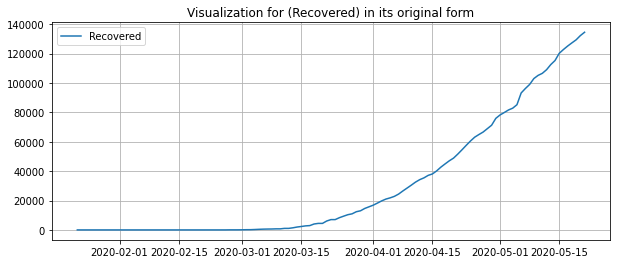

In [28]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [29]:
dfr.tail()

Recovered
Date                 
2020-05-17     125176
2020-05-18     127326
2020-05-19     129401
2020-05-20     132282
2020-05-21     134560

In [30]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [31]:
df_to_test.tail()

Recovered
Date                 
2020-05-17     125176
2020-05-18     127326
2020-05-19     129401
2020-05-20     132282
2020-05-21     134560

In [32]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [33]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [34]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [35]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [36]:
print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 50601.63794453122, 30182.95041322314)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 50601.63794453122, 30182.95041322314)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 40521.429573271664, 33450.60508162011)
([(0, 0, 0), (0, 0, 0, 365), 't'], 25053.911524638766, 21413.001447403276)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 19454.085513733462, 16802.901140723046)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 25584.035589026527, 15309.41545001549)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 21576.72513594983, 17528.64658548095)
([(0, 0, 1), (0, 0, 0, 365), 't'], 43300.44286042889, 37398.284847146024)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 11217.378058238675, 9461.232072306064)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 13616.204209445365, 8138.351425959926)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 24836.74703389891, 15423.885750927642)
([(0, 0, 2), (0, 0, 0, 365), 't'], 6990.080024537397, 6024.077348853389)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 20820.01001927139, 16657.388630091787)
([(0, 1, 0), (0, 0, 0, 365)

In [37]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Recovered
[(2, 1, 2), (0, 0, 0, 365), 't'] 713.3216091016599 398.3129611206366


In [38]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

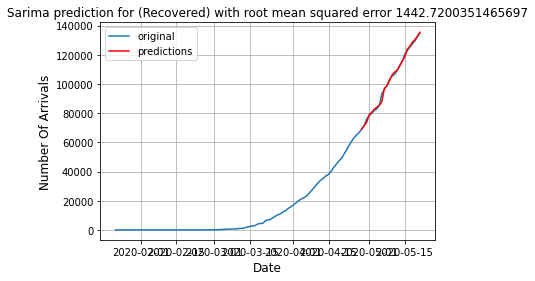

In [39]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [40]:
mape(test,predictions)

52.83942885574662

In [41]:
# Deaths cases

DEATH CASES

In [42]:
q=dataframe.query('Country=="Italy"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17   31908
2020-05-18   32007
2020-05-19   32169
2020-05-20   32330
2020-05-21   32486

[121 rows x 1 columns]

In [43]:
# Series to test
column_name = dfd.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Deaths cases will be used for the analysis


In [44]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [45]:
dfd.tail()

Deaths
Date              
2020-05-17   31908
2020-05-18   32007
2020-05-19   32169
2020-05-20   32330
2020-05-21   32486

In [46]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [47]:
df_to_test.tail()

Deaths
Date              
2020-05-17   31908
2020-05-18   32007
2020-05-19   32169
2020-05-20   32330
2020-05-21   32486

**Spliting the dataset**

In [48]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28   27359
2020-04-29   27682
2020-04-30   27967
2020-05-01   28236
2020-05-02   28710
2020-05-03   28884
2020-05-04   29079
2020-05-05   29315
2020-05-06   29684
2020-05-07   29958
2020-05-08   30201
2020-05-09   30395
2020-05-10   30560
2020-05-11   30739
2020-05-12   30911
2020-05-13   31106
2020-05-14   31368
2020-05-15   31610
2020-05-16   31763
2020-05-17   31908
2020-05-18   32007
2020-05-19   32169
2020-05-20   32330
2020-05-21   32486

In [49]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [50]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [51]:
#Generate all possible combinations of hyperparameters
  
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [52]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [54]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 17027.626650207098, 11605.851239669422)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 17027.626650207098, 11605.851239669422)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 12414.954613379485, 11416.707601939757)
([(0, 0, 0), (0, 0, 0, 365), 't'], 6010.24737155607, 5243.563096873457)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 4125.6425800547995, 3455.123229812878)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 8592.637850577456, 5879.81683674732)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 6622.707080254458, 5946.658340647197)
([(0, 0, 1), (0, 0, 0, 365), 't'], 3049.2885929804465, 2616.6596986140753)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 2245.967694402047, 1789.3381547203755)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 19851.80004048199, 13442.521408610624)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 13763.315379103926, 9392.02106188775)
([(0, 0, 2), (0, 0, 0, 365), 't'], 6665.435167739622, 5895.140861855513)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 1523.7053342359218, 1202.4356348275828)
([(0, 1, 0), (0, 0, 0, 365), '

In [55]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Deaths
[(2, 1, 2), (0, 0, 0, 365), 't'] 63.65240376420131 39.734862693226916


In [56]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

In [57]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [58]:
mape(testd,predictions)

5.907439631683857